# Style Transfer
  This one is a better style transfer representation than before

In [1]:
%matplotlib inline
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.metrics import categorical_accuracy
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
import keras
import keras.utils
#from keras.utils import to_categorical
from keras.utils.np_utils import to_categorical
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt


Using TensorFlow backend.


In [2]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input,decode_predictions
from keras import backend
import numpy as np
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave

img_path = 'horse.jpg'
horse = image.load_img(img_path,target_size=(224,224))
horse = image.img_to_array(horse)

style_path = 'style.jpg'
style = image.load_img(style_path,target_size=(224,224))
style = image.img_to_array(style)


In [3]:
horse = image.img_to_array(horse)
style = image.img_to_array(style)

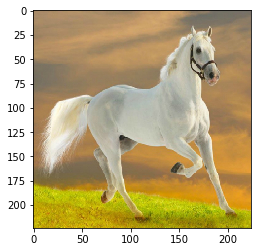

In [4]:
plt.imshow(horse/255.)

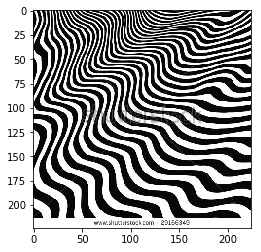

In [5]:
plt.imshow(style/255.)

In [6]:

horse= np.expand_dims(horse,axis=0)
horse = preprocess_input(horse)

style= np.expand_dims(style,axis=0)
style = preprocess_input(style)

horse[:, :, :, 0] -= 103.939
horse[:, :, :, 1] -= 116.779
horse[:, :, :, 2] -= 123.68
horse = horse[:, :, :, ::-1]

style[:, :, :, 0] -= 103.939
style[:, :, :, 1] -= 116.779
style[:, :, :, 2] -= 123.68
style = style[:, :, :, ::-1]

horse = backend.variable(horse)
style = backend.variable(style)
combination_image = backend.placeholder((1, 224, 224, 3), dtype='float32')

input_tensor = backend.concatenate([horse,style,combination_image], axis=0)


model = VGG16(input_tensor=input_tensor, weights='imagenet',include_top=False)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [7]:
layers = dict([(layer.name, layer.output) for layer in model.layers])
layers

{'block1_conv1': <tf.Tensor 'block1_conv1/Relu:0' shape=(3, 224, 224, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2/Relu:0' shape=(3, 224, 224, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool/MaxPool:0' shape=(3, 112, 112, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1/Relu:0' shape=(3, 112, 112, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2/Relu:0' shape=(3, 112, 112, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool/MaxPool:0' shape=(3, 56, 56, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1/Relu:0' shape=(3, 56, 56, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2/Relu:0' shape=(3, 56, 56, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3/Relu:0' shape=(3, 56, 56, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool/MaxPool:0' shape=(3, 28, 28, 256) dtype=float32>,
 'block4_conv1': <tf.Tensor 'block4_conv1/Relu:0' shape=(3, 28, 28, 512) dtype=float32>,
 'block4_co

In [8]:
content_weight = 0.5
style_weight = 0.25
total_variation_weight = 1.0

In [9]:
loss = backend.variable(0.)

In [10]:
def content_loss(content, combination):
    return backend.sum(backend.square(combination - content))

layer_features = layers['block2_conv2']
content_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]

loss += content_weight * content_loss(content_image_features,
                                      combination_features)

In [11]:
def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram

In [12]:
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = 224 * 224
    return backend.sum(backend.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

feature_layers = ['block1_conv2', 'block2_conv2',
                  'block3_conv3', 'block4_conv3',
                  'block5_conv3']
for layer_name in feature_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_features, combination_features)
    loss += (style_weight / len(feature_layers)) * sl

In [13]:
def total_variation_loss(x):
    a = backend.square(x[:, :223, :223, :] - x[:, 1:, :223, :])
    b = backend.square(x[:, :223, :223, :] - x[:, :223, 1:, :])
    return backend.sum(backend.pow(a + b, 1.25))

loss += total_variation_weight * total_variation_loss(combination_image)

In [14]:
grads = backend.gradients(loss, combination_image)

In [15]:
outputs = [loss]
outputs += grads
f_outputs = backend.function([combination_image], outputs)

def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

In [16]:
import time
height = 224
width = 224
x = np.random.uniform(0, 255, (1, height, width, 3)) - 128.

iterations = 10

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 1.00064e+12
Iteration 0 completed in 16s
Start of iteration 1
Current loss value: 9.26436e+11
Iteration 1 completed in 25s
Start of iteration 2
Current loss value: 9.01165e+11
Iteration 2 completed in 25s
Start of iteration 3
Current loss value: 8.89355e+11
Iteration 3 completed in 28s
Start of iteration 4
Current loss value: 8.82591e+11
Iteration 4 completed in 35s
Start of iteration 5
Current loss value: 8.7841e+11
Iteration 5 completed in 36s
Start of iteration 6
Current loss value: 8.75483e+11
Iteration 6 completed in 36s
Start of iteration 7
Current loss value: 8.73361e+11
Iteration 7 completed in 36s
Start of iteration 8
Current loss value: 8.71707e+11
Iteration 8 completed in 43s
Start of iteration 9
Current loss value: 8.70301e+11
Iteration 9 completed in 51s


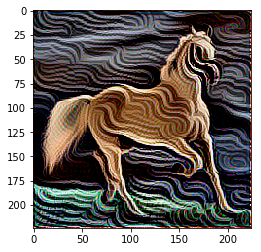

In [17]:
x = x.reshape((height, width, 3)).astype('float64')
x = x[:, :, ::-1]
x[ :, :, 0] += 103.939
x[:, :, 1] += 116.779
x[ :, :, 2] += 123.68
x = np.clip(x, 0, 244).astype('float64')

plt.imshow(x/255.)